# Narrative Analytics and Experimentation 
## Combining training and free trials to boost sales

**Teresa O'Neill**

**October, 2017**

ABC Video Technology* (*pseudonym) is a small software company specializing in forensic video analysis. Currently in its second year of operations, ABC Video Technology is cultivating a law enforcement customer base for its flagship product, XYZ Video Software* (*pseudonym), an application that streamlines the analysis of video evidence by allowing investigators and technicians to manage video in hundreds of proprietary digital formats. ABC Video Technology also provides training and technical support for XYZ Video Software. 

ABC Video Technology's certified forensic video analysts offer training workshops and technical presentations throughout the U.S. and internationally under the auspices of professional organizations. Workshops and presentations support the company's software marketing campaigns by including demonstrations of the product's functionality. In addition, ABC offers 30-day free trial licenses upon request to potential customers. 

With the ultimate goal of increasing software license sales, ABC Video Technology is considering offering free trials to all workshop attendees. ABC's experts have noticed that these events receive overwhelmingly positive feedback, and generate a lot of interest in the product, but that the momentum of this interest does not always carry through to a purchase. They hope that by coupling the training (which generates interest) with the trial license (which sustains interst), they will increase their conversion rate and shorten the time from first quote to purchase. Trial licenses cost the company \$10 each to produce and distribute, so they would like to test whether the change to their marketing strategy will be worthwhile.

The purpose of this request for comment is to propose an A/B test the **hypothesis** that distributing 30-day free trial licenses to workshop attendees will increase the proportion of attendees who purchase a license. The proposal is organized as follows:

- **Overview of the data**
- **Motivation for the test**
- **Rollout plan**
- **Evaluation plan**


### Overview of the data

The data examined in this report come from a set of four SalesForce reports generated by the ABC Video Technology management team: (i) training campaigns, (ii) trial licenses, (iii) all sales opportunities, and (iv) closed opportunities (successful sales). Below, we will get a sense for the structure of these files, and run some preliminary descriptive analyses. 

In [93]:
#preamble
import numpy as np
import pylab
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
%matplotlib inline
import datetime
from datetime import date
import time
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy import stats
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("Set2", 10)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [94]:
#Import the data
campaigns = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/campaigns.csv')
closed_opportunities = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/closed_opportunities.csv')
opportunities = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/opportunities.csv')
trials = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/trials.csv', na_values=['#NULL!'])

print('Training Campaigns:')
campaigns.head()

Training Campaigns:


,Campaign ID,Campaign Name,Start Date,End Date,Campaign Type,Contact ID,Member ID,First Name,Last Name,Agency ID,Agency Name
0,701610000003OXA,"AZ, Mesa: Homicide Conference",3/31/17,3/31/17,Presentation,00361000010T8VS,00v61000009xneZ,Eric,Lamb,0016100000QIfUh,Arizona Department of Public Safety
1,701610000007oHi,"AZ, Mesa: October 5-6, 2017",10/5/17,10/6/17,Investigators Two Day,00361000017pRz4,00v6100000C2NXU,Alan,Walker,0016100000QIfW2,Maricopa County Attorney's Office
2,701610000007oHi,"AZ, Mesa: October 5-6, 2017",10/5/17,10/6/17,Investigators Two Day,0036100001BKwzY,00v6100000Cuyp9,Jason,Flam,0016100000MAKw8,Mesa Police Department
3,701610000007oHi,"AZ, Mesa: October 5-6, 2017",10/5/17,10/6/17,Investigators Two Day,0036100001BKwsS,00v6100000CuynI,Kimberly,Figueroa,0016100000MAKw8,Mesa Police Department
4,701610000007oHi,"AZ, Mesa: October 5-6, 2017",10/5/17,10/6/17,Investigators Two Day,0036100001BKwmE,00v6100000CuymA,Jody,Hastings,0016100000MAKw8,Mesa Police Department


In the Training Campaigns dataset, we will focus on the Two-Day Investigator Trainings, which are offered most frequently, and which target customers who have not yet purchased the software. To date, 307 individuals from 119 different agencies have attended 18 Two-Day Investigator Trainings. The plot and summary below show that these workshops tend to be small, with a median of 27 attendees per workshop, and 3 agencies per workshop. 

Workshops to date:
18
count    307.000000
mean      26.941368
std       15.678442
min        3.000000
25%       12.000000
50%       27.000000
75%       40.000000
max       53.000000
Name: attendees, dtype: float64
Agencies in attendance:
119


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


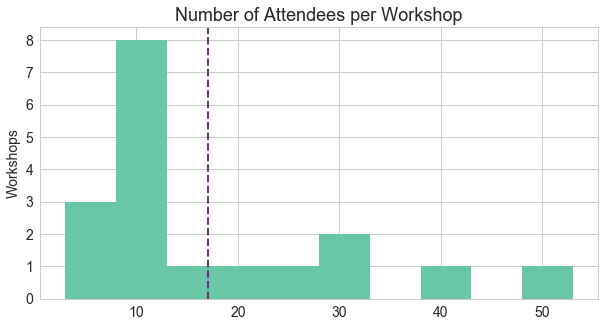

Number of agencies represented per workshop:
count    18.000000
mean      4.166667
std       7.800830
min       1.000000
25%       1.250000
50%       2.000000
75%       3.000000
max      35.000000
Name: agency_attend, dtype: float64


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [95]:
#Create a df with the relevant workshop type. 
investigator = campaigns[campaigns['Campaign Type']=='Investigators Two Day']
investigator['attendees'] = investigator.groupby('Campaign Name')['Campaign Name'].transform('count')

#Generate a few summaries.
print('Workshops to date:')
print(investigator['Campaign Name'].nunique())
print(investigator['attendees'].describe())
print('Agencies in attendance:')
print(investigator['Agency Name'].nunique())

attendees = investigator.drop_duplicates(subset='Campaign Name', keep="first")

#Plot the distribution of attendees per workshop. 
plt.figure(figsize=(10, 5))
ax = attendees['attendees'].plot(kind='hist', fontsize=14, color='#69c7a8')
plt.axvline(attendees['attendees'].mean(), color='#762a83', linestyle='dashed', linewidth=2)
plt.ylabel('Workshops', fontsize=14)
plt.title('Number of Attendees per Workshop')
plt.show()

#Check the distribution of agencies in attendance per workshop. 
investigator['agency_attend'] = investigator.groupby(['Campaign Name', 'Agency Name'])['Campaign Name'].transform('count')
agencies = investigator.drop_duplicates(subset='Campaign Name', keep="first")

#Check the distribution of attendees per workshop. 
print('Number of agencies represented per workshop:')
print(agencies['agency_attend'].describe())

In [96]:
print('Trial Licenses:')
print(len(trials))
trials.head()

Trial Licenses:
248


,Agency Name,Agency ID,Full Name,Contact ID,License Sent,Trial Expiration
0,"Nexotek, LLC",0016100000MAKwH,Mark Andrews,0036100000JtofL,03/03/16,06/25/16
1,Middlesex County Prosecutor's Office,0016100000ULNga,Matthew Domanic,0036100000VXatp,04/12/16,05/12/16
2,Ottawa Police Service,0016100000MAKwT,Michael Ross,0036100000OO5j4,04/14/16,05/14/16
3,RCMP - Forensic Video Analysis Unit,0016100000MAKwi,Jon Stringer,0036100000S5nFU,04/18/16,05/19/16
4,York Regional Police,0016100000MAKx9,Scott Olar,0036100000Jtogc,04/19/16,05/19/16


In [97]:
#Clean the date objects.
today = datetime.date.today()
today = pd.to_datetime(today)

trials['License Sent'] = pd.to_datetime(trials['License Sent'])
trials['Trial Expiration'] = pd.to_datetime(trials['Trial Expiration'])

closed_opportunities['Close Date'] = pd.to_datetime(closed_opportunities['Close Date'])
closed_opportunities['Past Close'] = closed_opportunities['Close Date'].apply(lambda x: np.nan if x > today else x)
closed_opportunities['Past Close'] = pd.to_datetime(closed_opportunities['Past Close'])

In [98]:
print('Closed Sofware Sales:')
license_sales = closed_opportunities[closed_opportunities['Product Name']=='iNPUT-ACE Software']
print(len(license_sales))
closed_opportunities.head()

Closed Sofware Sales:
196


,Opportunity ID,Opportunity Name,Primary Contact,Agency ID,Agency Name,Created Date,Probability (%),Stage,Close Date,Amount,Quantity,Product Family,Sales Price,Total Price,Product Code,Product Name,Past Close
0,0066100000H6fxM,1T(Investigator) - Gustafson,J. Spencer Gustafson,0016100000QGmaV,Wisconsin Department of Justice,05/26/17,100,Stage 4: Closed Won,2017-03-22,395.00,1.0,Investigator Courses,395.00,395.00,3500.0,Two-Day Investigator Training,2017-03-22
1,0066100000H6fut,2T(Investigator) - Asmus,Larissa Asmus,0016100000UNIun,Appleton Police Department,05/26/17,100,Stage 4: Closed Won,2017-04-13,790.00,2.0,Investigator Courses,395.00,790.00,3500.0,Two-Day Investigator Training,2017-04-13
2,0066100000H6g4h,1T(Investigator) - Serkedakis,Nickolas Serkedakis,0016100000rCx3W,Cheyenne Police Department,05/26/17,100,Stage 4: Closed Won,2017-05-02,395.00,1.0,Investigator Courses,395.00,395.00,3500.0,Two-Day Investigator Training,2017-05-02
3,0066100000H7ce8,2T(Investigator) - Reid,Mark Reid,00161000015Iz15,Seattle Pacific University Office of Safety an...,06/14/17,100,Stage 4: Closed Won,2017-06-27,790.00,2.0,Investigator Courses,395.00,790.00,3500.0,Two-Day Investigator Training,2017-06-27
4,0066100000FFjRs,"_Expenses: TX, Houston: April 19-20, 2017",Campaign Expenses,0016100000y7eU2,Occam Video Solutions,03/27/17,100,Stage 4: Closed Won,2017-04-19,-3602.25,1.0,Investigator Courses,-3602.25,-3602.25,8014.0,Investigator Course Expenses,2017-04-19


Closed Sales include sales of sofware licenses, support packages, training seats, and companion licenses. For the purposes of this test, we will focus only on sales of software licenses. So far, 196 licenses have been sold. (While some agencies have purchased multiple licenses, we will set aside the question of quantity at present.)

In [99]:
print('All Opportunities:')
opportunities.head()

All Opportunities:


,Opportunity ID,Opportunity Name,Primary Contact,Agency ID,Agency Name,Created Date,Probability (%),Stage,Close Date,Amount,Quantity,Product Family,Sales Price,Total Price,Product Code,Product Name
0,6.61E+12,1L - East Hampton Town PD,Rob Gurney,0016100000ULdlT,East Hampton Town Police Department,4/12/16,0,Closed Lost,7/24/17,4290.0,NaN,NaN,NaN,4290.0,NaN,NaN
1,00661000006xExy,"1L, 1T - Kennedy",Jim Kennedy,0016100000MAKwG,New York State Police,12/30/15,100,Stage 4: Closed Won,12/11/15,3290.0,1.0,Hands-on Training,795.0,795.0,3700.0,Hands-on Training
2,00661000006xExy,"1L, 1T - Kennedy",Jim Kennedy,0016100000MAKwG,New York State Police,12/30/15,100,Stage 4: Closed Won,12/11/15,3290.0,1.0,Software,2995.0,2995.0,8050.0,Video Software
3,00661000006xExy,"1L, 1T - Kennedy",Jim Kennedy,0016100000MAKwG,New York State Police,12/30/15,100,Stage 4: Closed Won,12/11/15,3290.0,1.0,Software,-500.0,-500.0,8051.0,LEVA Discount
4,00661000006xHSV,2L - Wedderien,Rhona Wedderien,0016100000MAKwx,Tarrant County District Attorney's Office,12/30/15,100,Stage 4: Closed Won,6/28/16,6990.0,2.0,Software,3495.0,6990.0,1100.0,Video Software


The dataset documenting all opportunities gives a more comprehensive picture of ABC Video's sales pipeline, including lost opportunities, prospective customers, and customers who are currently considering quotes, or who have committed to a purchase. 

### Motivation for the test

We will test the hypothesis that distributing 30-day free trial licenses to all workshop attendees, rather than only upon request, will significantly increase the proportion of attendees who purchase a software license within 60 days of the workshop. 

This hypothesis is couched in the context that, while both workshops and free trials are successful in generating interest in the product, free trials have not been leveraged as well as they could be. Offering the trials at the end of the workshop could allow the company to strike while the iron is hot, and ensure (ideally through follow-ups) that interested workshop attendees are drawn into the sales pipeline. 

Of the 307 workshop attendees, so far 191 (38.8%) have purchased licenses; 76 of the 248 (30.6%) trial recipients purchased licenses. While workshop attendees who purchased did so on average 40 days (median 35 days) after the workshop, free trial recipients who purchased did so after 110 days (median 80 days). 

In [100]:
#Of agencies attending training campaigns and presentations, how many also purchase software/final training?
campaigns2 = pd.merge(investigator, license_sales, on='Agency ID', how='left')
trials2 = pd.merge(trials, license_sales, on='Agency ID', how='outer')
print(len(campaigns2))
print(len(trials2))
#Let's see how many did purchase, as a proportion.
119/(len(investigator))
76/(len(trials))

343
383


0.3064516129032258

In [101]:
#Create a variable to track how long after campaign attendance the customer makes a purchase.
campaigns2['End Date'] = pd.to_datetime(campaigns2['End Date'])
campaigns2['Past Campaign'] = campaigns2['End Date'].apply(lambda x: np.nan if x > today else x)
campaigns2['Past Campaign'] = pd.to_datetime(campaigns2['Past Campaign'])

campaigns2['Difference1'] = campaigns2['Past Close'] - campaigns2['Past Campaign']
campaigns2['Difference1'] = campaigns2['Difference1'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
campaigns2['Difference1'] = campaigns2['Difference1'].apply(lambda x: np.nan if x<0 else x)

#Distribution of time from training to purchase.
campaigns2['Difference1'].describe()

count    119.000000
mean      40.344538
std       48.227645
min        2.000000
25%        2.000000
50%       35.000000
75%       40.000000
max      280.000000
Name: Difference1, dtype: float64

In [102]:
#Compute time from trial license to purchase.
trials2['Difference2'] = trials2['Past Close'] - trials2['License Sent']
trials2['Difference2'] = trials2['Difference2'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
trials2['Difference2'] = trials2['Difference2'].apply(lambda x: np.nan if x<0 else x)

#Distribution of time from training to purchase.
trials2['Difference2'].describe()

count     76.000000
mean     110.986842
std      107.628186
min        0.000000
25%       34.750000
50%       80.500000
75%      143.250000
max      421.000000
Name: Difference2, dtype: float64

Both workshops and free trials have the potential to draw new customers into the sales funnel, but we might be able to do better than 30.6% conversion after free trials.

### Rollout plan

The A/B test will be implemented over the course of six months. The sample will consist of 10 workshops of mixed sizes and compositions (in terms of agencies) and in a variety of locations around the U.S. The long testing period is a consequence of the fact that workshops tend to be offered about two weeks apart. 250 individuals and 40 agencies are anticipated in the sample, based on conservative estimates from the means. Since the sample size is quite small, the control group, where free trials are not automatically distributed, will include both historical data from past workshops and data gathered over the course of the test. 

Workshops will be assigned pseudorandomly to either the control or test groups, to counterbalance for workshop size, agency diversity, and location. Individuals who previously requested trial licenses and control group individuals who happen to request trial licenses independently will be excluded from the test to avoid contamination. Cross-contamination remains a risk, since law enforcement professionals from different workshops could discuss the product, but it is relatively unlikely. 

Because the trial licenses cost /$10 each to distribute, rollout of the test group will begin at 20\%. At the conclusion of the test workshops, 30-day free trial licenses will be distributed to all attendees. Given that 75\% of workshop attendees who converted in the past did so within 40 days of the workshop, at six weeks after the workshop, a benchmark will be set to analyze the difference between the two groups. If there is no difference, rollout will increase to 50\% for an additional six weeks; if there is a significant difference, conclude that distributing free trials at workships is effective and meet to discuss the implementation of new practices with the executive team.

### Evaluation Plan

For the free trial distribution plan to be considered more effective than the old "upon request" strategy, we will compare sales rates, using a threshold of p\<0.05. Sales rate is defined as the proportion of workshop attendees who purchase a software license within six weeks of attendance. An additional metric that we will use is sales rate by agency: do agencies represented in the test group have a higher purchase rate than agencies in the control group? If the tested strategy proves effective, this additional metric will help the executive team decide whether and how to limit the number of free trials per agency.

Since the trial licenses cost /$10 to distribute, we will also run a cost/benefit analysis of implementing the new trial distribution plan. Does the increase in sales, if there is one, offset the cost of giving a license to every workshop attendee. That is, does the test group yield significantly higher net revenue than the control group (at 50\% rollout)?

An additional factor that will be considered is the time to purchase. The analysis of past data shows that license purchases occur on average 40 days after the end of the workshop. How does the distribution of the free trial license affect how quickly sales are completed? What, if any, is the relationship between the number of attendees per agency at the workshop and the sales rate by agency?

A pitfall of this evaluation plan is the small sample size. The real-world context of this test limits the potential sample size, and thus, its statistical power; even if the result is not significant, the executive team might risk implementing the new strategy on the basis of a non-significant difference between the test and control groups. 

An additional contextual challenge stems from the relationship between individual attendees/customers, and agencies. Some agencies send several individuals to the workshops, while others send one or two; nevertheless, the purchasing power comes from the agency. 

Agencies also differ from one another with respect to their capacity and use cases: in some cases, an agency uses a single license in one office or work station, while in other cases, separate units within an agency may purchase and use their own licenses. The test, as designed, tracks individual, rather than agency purchasing behavior, because data on the specific use cases of each individual and each agency are not yet available. The executive team is considering a plan to collect such data through activation surveys in the future.